In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from random import randint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import json
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Extract data in a dataframe
reviews = []
scores = []
n = 0
with open("/drive/My Drive/6.7900 project/reviews_Amazon_Instant_Video_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        reviews.append(loaded["reviewText"])
        scores.append(loaded["overall"])
        n += 1

In [ ]:
print(len(reviews))

37126


In [ ]:
# Create input and label
label = [[0,0,0,0,0] for _ in scores]
inp = reviews
for idx in range(len(scores)):
    curr_score = int(scores[idx]) - 1
    label[idx][curr_score] = 1

In [ ]:
# Randomize
for idx in range(1, n):
    rand = randint(0, idx)
    label[idx], label[rand] = label[rand], label[idx]
    inp[idx], inp[rand] = inp[rand], inp[idx]
label = np.array(label)
inp = np.array(inp)

In [ ]:
# Tokenize, encode, and pad
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(inp)
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Baseline Model
embedding_vector_length = 32
vocab_size = len(tokenizer.word_index)
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
baseline_model.add(SpatialDropout1D(0.25))
baseline_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(5, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           1908416   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1,925,271
Trainable params: 1,925,271
Non-trainable params: 0
______________________________________________

In [ ]:
# Training
training = baseline_model.fit(padded_sequence,label,validation_split=0.2, epochs=25, batch_size=32)

Epoch 1/25
929/929 [==============================] - 149s 158ms/step - loss: 1.0640 - accuracy: 0.5793 - val_loss: 0.9440 - val_accuracy: 0.6100
Epoch 2/25
929/929 [==============================] - 147s 158ms/step - loss: 0.9243 - accuracy: 0.6178 - val_loss: 0.9152 - val_accuracy: 0.6287
Epoch 3/25
929/929 [==============================] - 145s 156ms/step - loss: 0.8936 - accuracy: 0.6334 - val_loss: 0.9151 - val_accuracy: 0.6223
Epoch 4/25
929/929 [==============================] - 149s 160ms/step - loss: 0.8562 - accuracy: 0.6416 - val_loss: 0.8833 - val_accuracy: 0.6359
Epoch 5/25
929/929 [==============================] - 146s 157ms/step - loss: 0.8224 - accuracy: 0.6569 - val_loss: 0.9037 - val_accuracy: 0.6286
Epoch 6/25
929/929 [==============================] - 149s 160ms/step - loss: 0.8079 - accuracy: 0.6644 - val_loss: 0.8800 - val_accuracy: 0.6382
Epoch 7/25
929/929 [==============================] - 148s 159ms/step - loss: 0.7945 - accuracy: 0.6696 - val_loss: 0.9564 -

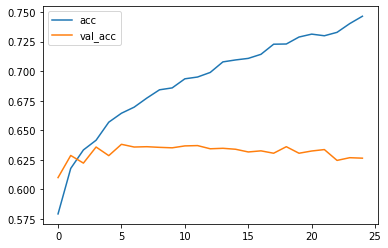

In [ ]:
# Plot Accuracy
plt.plot(training.history['accuracy'], label='acc')
plt.plot(training.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

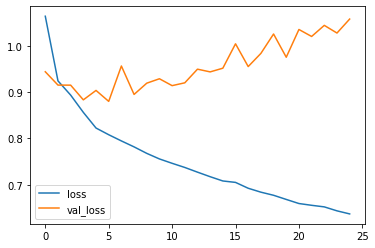

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = baseline_model.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
# Extract new data
reviews = []
scores = []
with open("/drive/My Drive/6.7900 project/Digital_Music_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        if "reviewText" in loaded and "overall" in loaded:
            reviews.append(loaded["reviewText"])
            scores.append(loaded["overall"])

In [ ]:
# Randomize sequence
for idx in range(1, n):
    rand = randint(0, idx)
    scores[idx], scores[rand] = scores[rand], scores[idx]
    reviews[idx], reviews[rand] = reviews[rand], reviews[idx]

In [ ]:
# Find accuracy in new data
correct = 0
total = 10000
for idx in tqdm(range(total)):
    if predict_sentiment(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [08:02<00:00, 20.75it/s]

accuracy = 0.7681


In [ ]:
cap = 1000
# Create new input and label
label = [[0,0,0,0,0] for _ in range(cap)]
inp = reviews[total : total + cap]
for idx in range(total, total + cap):
    curr_score = int(scores[idx]) - 1
    label[idx - total][curr_score] = 1
label = np.array(label)

In [ ]:
# Encode and pad
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Architecture
domain_adapt = keras.models.clone_model(baseline_model)
domain_adapt.set_weights(baseline_model.get_weights())
domain_adapt.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
domain_adapt.layers[0].trainable = False
print(domain_adapt.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           1908416   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1,925,271
Trainable params: 16,855
Non-trainable params: 1,908,416
_________________________________________

In [ ]:
# Training
training_adapt = domain_adapt.fit(padded_sequence,label,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 9s 201ms/step - loss: 0.6744 - accuracy: 0.7837 - val_loss: 0.5278 - val_accuracy: 0.8350
Epoch 2/10
25/25 [==============================] - 3s 128ms/step - loss: 0.5873 - accuracy: 0.8163 - val_loss: 0.5084 - val_accuracy: 0.8550
Epoch 3/10
25/25 [==============================] - 3s 128ms/step - loss: 0.5545 - accuracy: 0.8263 - val_loss: 0.5074 - val_accuracy: 0.8600
Epoch 4/10
25/25 [==============================] - 3s 126ms/step - loss: 0.5159 - accuracy: 0.8363 - val_loss: 0.5147 - val_accuracy: 0.8450
Epoch 5/10
25/25 [==============================] - 3s 127ms/step - loss: 0.4976 - accuracy: 0.8338 - val_loss: 0.5200 - val_accuracy: 0.8500
Epoch 6/10
25/25 [==============================] - 3s 130ms/step - loss: 0.4753 - accuracy: 0.8450 - val_loss: 0.5261 - val_accuracy: 0.8400
Epoch 7/10
25/25 [==============================] - 3s 131ms/step - loss: 0.4674 - accuracy: 0.8475 - val_loss: 0.5405 - val_accuracy: 0.8350
Epoch 

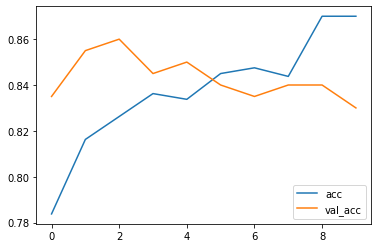

In [ ]:
# Plot Accuracy
plt.plot(training_adapt.history['accuracy'], label='acc')
plt.plot(training_adapt.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

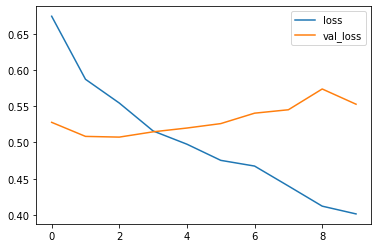

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training_adapt.history['loss'], label='loss')
plt.plot(training_adapt.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function for domain adapt
def predict_sentiment_adapt(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = domain_adapt.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
correct = 0
for idx in tqdm(range(total)):
    if predict_sentiment_adapt(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [08:29<00:00, 19.64it/s]

accuracy = 0.8101
